# Regressors: orthogonalise RT regressors

In [33]:
import numpy as np
from random import shuffle as sfl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
import scipy
import itertools
from scipy.linalg import sqrtm, inv
from scipy import stats


%matplotlib inline


### Define hrf functions 

In [36]:
def spm_Gpdf(s,h,l):
    s = np.array(s)
    res = (h-1)*np.log(s) + h*np.log(l) - l*s - np.log(gamma(h))
    return np.exp(res)

def canonical(resolution):
    # translated from spm_hrf
    p=[6,16,1,1,6,0,32]
    dt = resolution/16.
    s = np.array(xrange(int(p[6]/dt+1)))
    #HRF sampled at 0.1 s
    hrf = spm_Gpdf(s,p[0]/p[2],dt/p[2]) - spm_Gpdf(s,p[1]/p[3],dt/p[3])/p[4]
    hrf = hrf[[int(x) for x in np.array(xrange(int(p[6]/resolution+1)))*16.]]
    hrf = hrf/np.sum(hrf)
    # duration of the HRF
    durhrf = 32.0
    # length of the HRF parameters in resolution scale
    laghrf = int(np.ceil(durhrf/resolution))
    hrf = hrf[:laghrf]

    return {"basishrf":hrf,"laghrf":laghrf}

### What does an orthogonalised RT regressor look like?

Orthogonalisation as in Jeanette's slides for the bootcamp:

$X_2 = \beta_1X_1 + \epsilon$


$X_2^{ortho} = X2 - \hat\beta_1X_1$


slope: 0.753967


/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


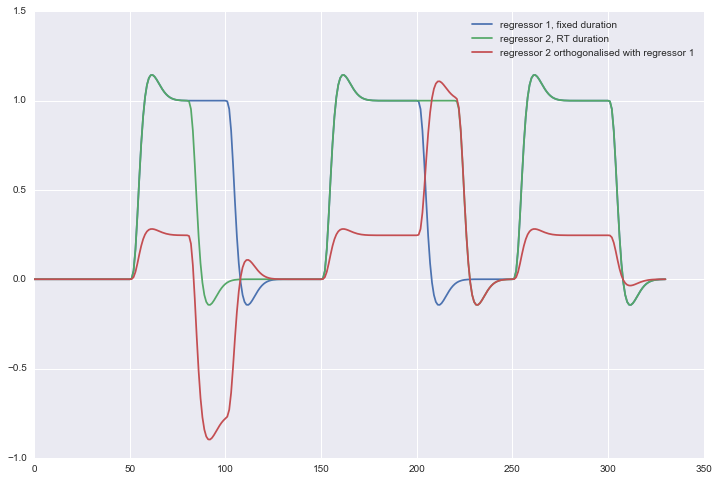

In [83]:
X1 = np.zeros(300)
X1[range(50,100)+range(150,200)+range(250,300)]=1
reg_X1 = np.convolve(X1,canonical(1)['basishrf'][:len(X1)])
X2 = np.zeros(300)
X2[range(50,80)+range(150,220)+range(250,300)]=1
reg_X2 = np.convolve(X2,canonical(1)['basishrf'][:len(X2)])

fit = stats.linregress(reg_X1,reg_X2)
print("slope: %f"%fit.slope)
reg_X2_ortho = reg_X2-fit.slope*reg_X1

plt.figure(figsize=(12,8))
plt.plot(reg_X1,label="regressor 1, fixed duration")
plt.plot(reg_X2,label="regressor 2, RT duration")
plt.plot(reg_X2_ortho,label="regressor 2 orthogonalised with regressor 1")
plt.legend()

slope: 0.434954


/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


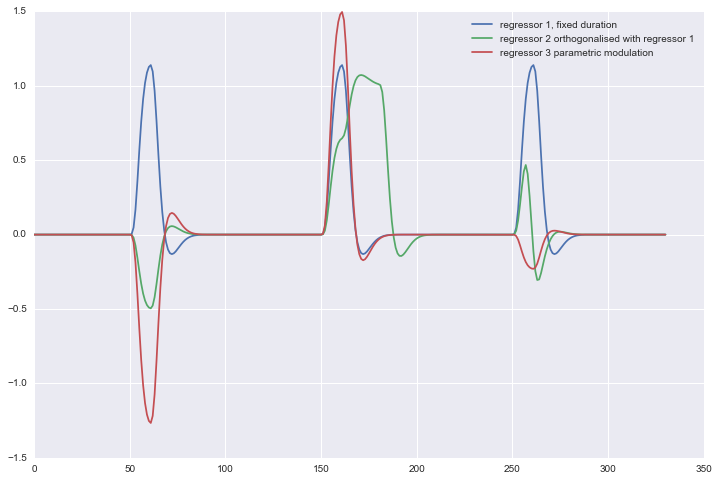

In [99]:
durfix = 10
durflex = np.array([-20,20,-5])

X1 = np.zeros(300)
X1[range(50,50+durfix)+range(150,150+durfix)+range(250,250+durfix)]=1
reg_X1 = np.convolve(X1,canonical(1)['basishrf'][:len(X1)])
X2 = np.zeros(300)
X2[range(50,50+durfix+durflex[0])+range(150,150+durfix+durflex[1])+range(250,250+durfix+durflex[2])]=1
reg_X2 = np.convolve(X2,canonical(1)['basishrf'][:len(X2)])
X3 = np.zeros(300)
durflex_st = (durflex-np.mean(durflex))/np.std(durflex)
X3[range(50,50+durfix)] = 1*durflex_st[0]
X3[range(150,150+durfix)] = 1*durflex_st[1]
X3[range(250,250+durfix)] = 1*durflex_st[2]
reg_X3 = np.convolve(X3,canonical(1)['basishrf'][:len(X3)])

fit = stats.linregress(reg_X1,reg_X2)
print("slope: %f"%fit.slope)
reg_X2_ortho = reg_X2-fit.slope*reg_X1

X = np.array([reg_X1,reg_X2_ortho,reg_X3])

plt.figure(figsize=(12,8))
plt.plot(reg_X1,label="regressor 1, fixed duration")
#plt.plot(reg_X2,label="regressor 2, RT duration")
plt.plot(reg_X2_ortho,label="regressor 2 orthogonalised with regressor 1")
plt.plot(reg_X3,label="regressor 3 parametric modulation")
plt.legend()

[[  1.00000000e+00  -3.80144855e-17   1.56747480e-17]
 [ -3.80144855e-17   1.00000000e+00   4.38211878e-01]
 [  1.56747480e-17   4.38211878e-01   1.00000000e+00]]


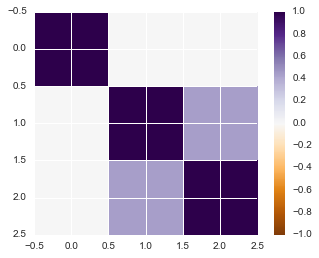

In [105]:
plt.imshow(np.corrcoef(X),interpolation="nearest", vmin=-1, vmax=1, cmap='PuOr')
plt.colorbar()
print(np.corrcoef(X))